# Inscopix CNMFe Demo

This notebook demonstrates how to use the Inscopix CNMFe package to extract and visualize the spatial footprints and temporal dynamics of neurons in a 1-photon calcium imaging movie recorded in the mouse dorsal striatum. Before using this notebook, you will need to install the dependencies listed below:

`pip install inscopix-cnmfe scikit-image pandas matplotlib`

## Import required packages

In [1]:
import inscopix_cnmfe
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Run cnmfe on a sample movie

In [2]:
inscopix_cnmfe.run_cnmfe(
    input_movie_path='test/data/movie.tif', 
    output_dir_path='output', 
    output_filetype=0,
    average_cell_diameter=7,
    min_corr=0.8,
    min_pnr=10.0,
    gaussian_kernel_size=0,
    closing_kernel_size=0,
    background_downsampling_factor=2,
    ring_size_factor=1.4,
    merge_threshold=0.7,
    num_threads=4,
    processing_mode=2,
    patch_size=80,
    patch_overlap=20,
    trace_output_units=1
)

## Read and load footprints and traces into memory

In [3]:
footprints = io.imread('output/movie_footprints.tiff')
traces = pd.read_csv('output/movie_traces.csv')

# Visualize the spatial footprint and temporal dynamics of neurons identified using CNMFe

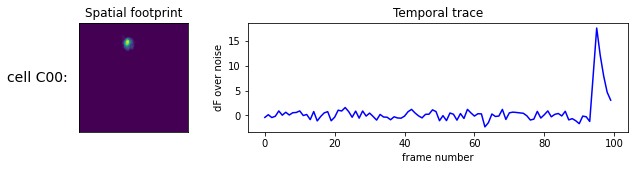

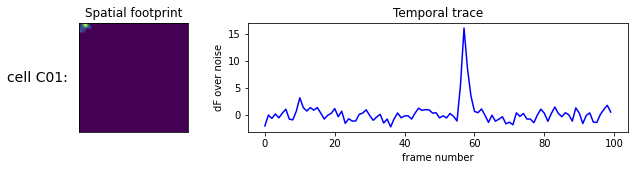

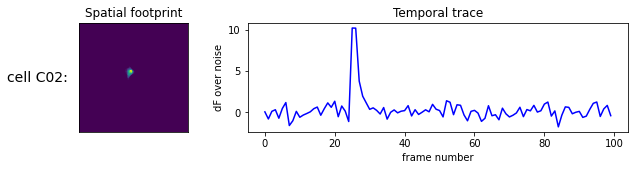

In [4]:
# number of neurons we wish to visualize
num_neurons = 3

for neuron_index in range(num_neurons):
    neuron_name = traces.columns[neuron_index + 1]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 3]})

    # spatial footprint
    axes[0].imshow(footprints[neuron_index])
    axes[0].set_title("Spatial footprint")
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # temporal dynamics
    axes[1].set_title("Temporal trace")
    axes[1].plot(traces[neuron_name], label='neuron {0}'.format(neuron_name), color='blue')
    axes[1].set_ylabel("dF over noise")
    axes[1].set_xlabel("frame number")
    
    plt.suptitle(
        'cell {0}:'.format(neuron_name), 
        x=0.08,
        y=0.55,
        fontsize=14
    )

    plt.show()

## View all cell footprints in a grid

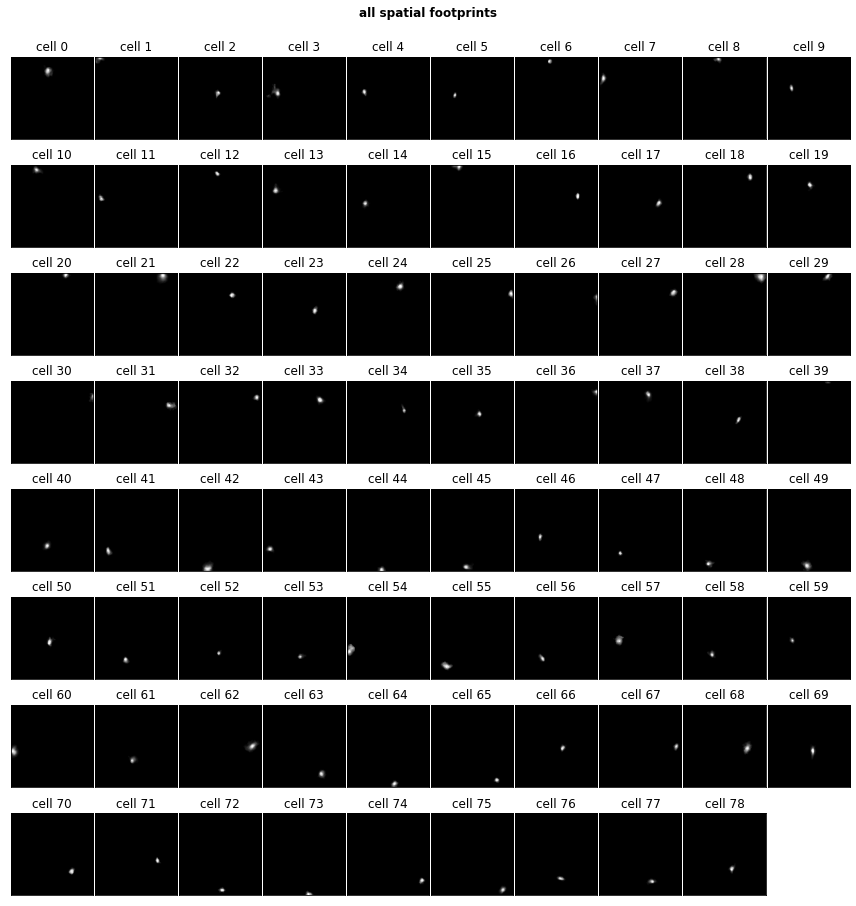

In [5]:
n_cols = 10
n_rows = int(np.ceil(np.shape(footprints)[0]/n_cols))
fig, ax = plt.subplots(
    n_rows, 
    n_cols, 
    figsize=(12,1.6*n_rows), 
    sharex=True, 
    sharey=True
)
for ii in range(len(ax.flatten())):
    try:
        ax.flatten()[ii].imshow(footprints[ii], cmap='gray')
        ax.flatten()[ii].set_title("cell {}".format(ii))
        ax.flatten()[ii].grid(False)
        ax.flatten()[ii].set_xticks([])
        ax.flatten()[ii].set_yticks([])
    except IndexError:
        # turn off axes for where cell doesn't exist
        ax.flatten()[ii].axis('off')
fig.tight_layout()
fig.subplots_adjust(wspace=0.025, hspace=0.2, top=0.93)
fig.patch.set_facecolor('white')
fig.suptitle('all spatial footprints', fontweight='bold');

## Create a composite image of all ROIS in the field of view
assign random colors to each

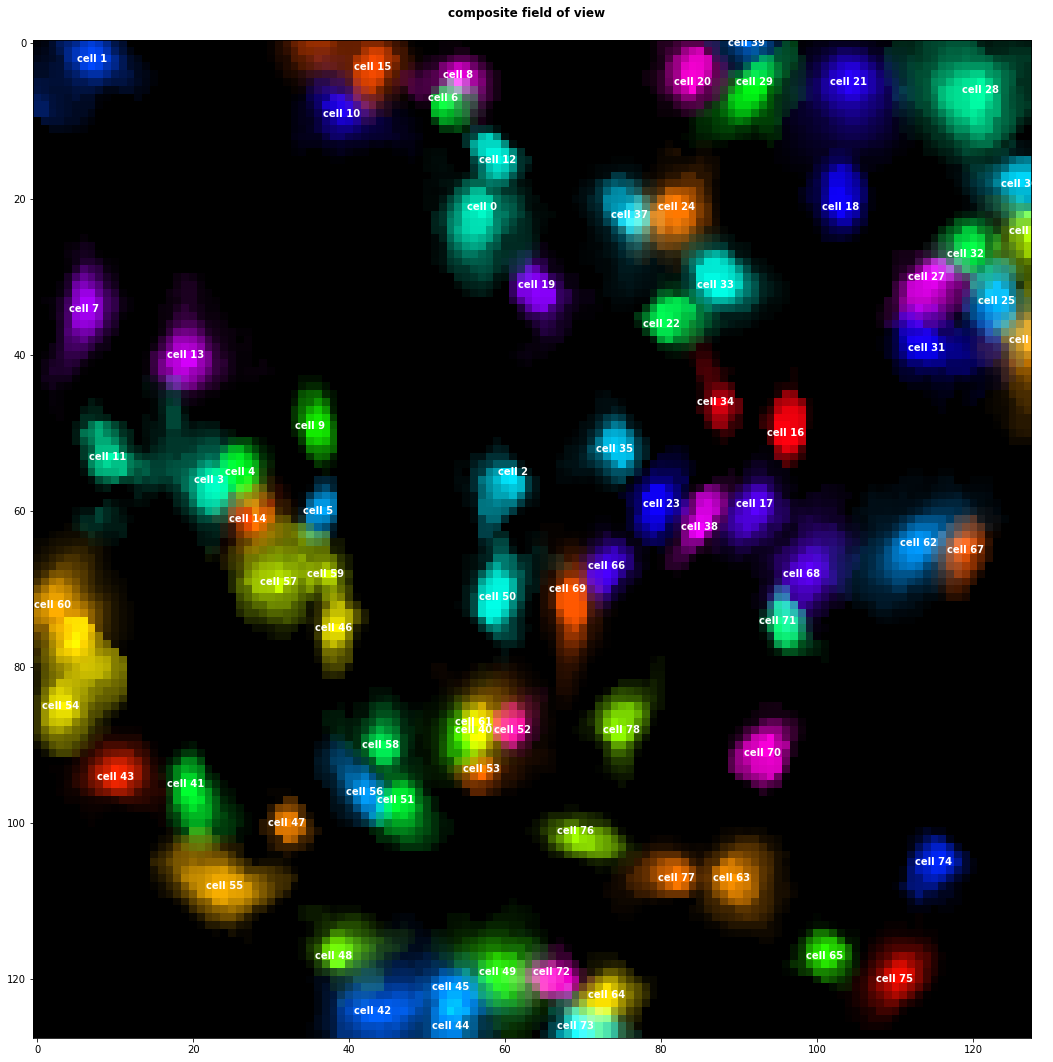

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
composite_fov = np.zeros((footprints.shape[1], footprints.shape[2], 3))
cmap_vals = cm.get_cmap('gist_rainbow')
np.random.seed(0)
for cell_id in range(footprints.shape[0]):
    # select a random color for this cell
    color = cmap_vals(np.random.rand())
    
    # assign the color to each of the three channels, normalized by the footprint peak
    for color_channel in range(3):
        composite_fov[:,:,color_channel] += color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])

# set all values > 1 (where cells overlap) to 1:
composite_fov[np.where(composite_fov > 1)] = 1

# show the image
ax.imshow(composite_fov[:,:,:])

# annotate each cell with a label centered at its peak
for cell_id in range(footprints.shape[0]):
    peak_loc = np.where(footprints[cell_id]==np.max(footprints[cell_id]))
    ax.text(
        peak_loc[1][0], 
        peak_loc[0][0], 
        'cell {}'.format(cell_id), 
        color='white', 
        ha='center', 
        va='center',
        fontweight='bold',
    )
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.patch.set_facecolor('white')
fig.suptitle('composite field of view', fontweight='bold');